In [1]:
import cv2
import nd2
import numpy as np
import pandas as pd

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.color import label2rgb
from scipy import ndimage as ndi

from matplotlib import pyplot as plt
%matplotlib inline

In [15]:
from matplotlib.colors import LinearSegmentedColormap
cmap_r = LinearSegmentedColormap.from_list('real_red', [(0,0,0), (1,0,0)], N=1000)
cmap_g = LinearSegmentedColormap.from_list('real_blue', [(0,0,0), (0,1,0)], N=1000)
cmap_b = LinearSegmentedColormap.from_list('real_green', [(0,0,0), (0,0,1)], N=1000)

In [3]:
with nd2.ND2File('nDAO_10min_D-NrV_40min_H2O2_09-03-22.nd2') as f:
    data = f.metadata
    frames = f.asarray()

In [4]:
# nd2 file format can contain several areas detected simultaneously, 
# to uniform the data this code divide it into separate arrays (confocal_img_zones)

if len(frames.shape) == 5:
    num_of_zones = frames.shape[1]

    # creaing a list of different zones with applicable format  (['time series', 'channels', 'Y', 'X'])
    confocal_img_zones = []
    for zone_index in range(num_of_zones):
        confocal_img_zones.append(frames[:,zone_index])

In [27]:
def plot_image(x, size=10, camp='gray'):
    plt.figure(figsize=(size, size))
    plt.imshow(x, cmap=camp)
    plt.axis('off')

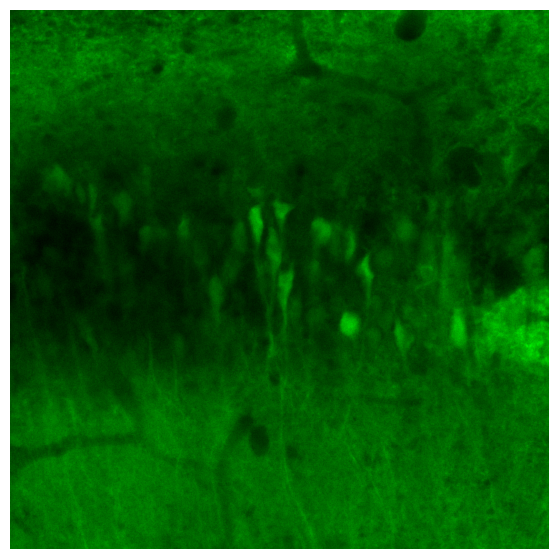

In [31]:
plot_image(confocal_img_zones[0][0,1,:,:], 7, camp=cmap_g)

In [33]:
def find_cells_and_get_bboxes(frame):
    '''Detect cells in the given frame (the snapshot in one moment of time),
    return bounding boxes, contours of each cell and image of contours.
    '''

    # Changing channel scale of every gray image pixel to standard value from 0 to 255
    normalized_frame = np.zeros((frame.shape[0],frame.shape[1], 1), np.uint8)

    old_min_value = np.min(frame)
    old_max_value = np.max(frame)
    old_range = old_max_value - old_min_value

    for row in range(frame.shape[0]):
        for column in range(frame.shape[0]):
            normalized_frame[row,column] = ((frame[row,column] - old_min_value) * 255) / old_range


    # frame preprocessing
    blurred = cv2.medianBlur(normalized_frame,3)
    thresh = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,121,2)
    kernel = np.ones((8,8),np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    contours = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0]

    # We obtain separeted cells as well as ones sticked together (clumped cells)
    blank_image = np.zeros((frame.shape[0],frame.shape[1], 1), np.uint8)

    separated_cells = blank_image.copy()
    clumped_cells = blank_image.copy()

    for cnt in contours:
        area = cv2.contourArea(cnt)
        if 3000 > area > 800:
            hull = cv2.convexHull(cnt)
            cv2.drawContours(separated_cells, [hull], 0, (255,255,255), cv2.FILLED)
        if area > 3000:
            cv2.drawContours(clumped_cells, [cnt], 0, (255,255,255), cv2.FILLED)

    cells = list(cv2.findContours(separated_cells, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[0])

    # Watershed segmentation of clumped cells -> divided cells

    clumped_cells = cv2.GaussianBlur(clumped_cells,(7,7),0)

    distance = ndi.distance_transform_edt(clumped_cells)
    coords = peak_local_max(distance, footprint=np.ones((40, 40)))
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(-distance, markers, mask=clumped_cells)

    for label in np.unique(labels):

        if label == 0:
            continue

        mask = np.zeros(labels.shape, dtype="uint8")

        mask[labels == label] = 255
        cell_contour = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0][0]
        hull = cv2.convexHull(cell_contour)
        cells.append(hull)

    cells_contours = blank_image.copy()
    cv2.drawContours(cells_contours, cells, -1, (255,255,255), 2)

    bboxes_of_cells = []

    for cell in cells:
        bbox = cv2.boundingRect(cell)
        bboxes_of_cells.append(bbox)

    return bboxes_of_cells, cells, cells_contours

In [37]:
initial_bboxes_of_cells, _, initial_contours_of_cells = find_cells_and_get_bboxes(confocal_img_zones[0][0,2,:,:])

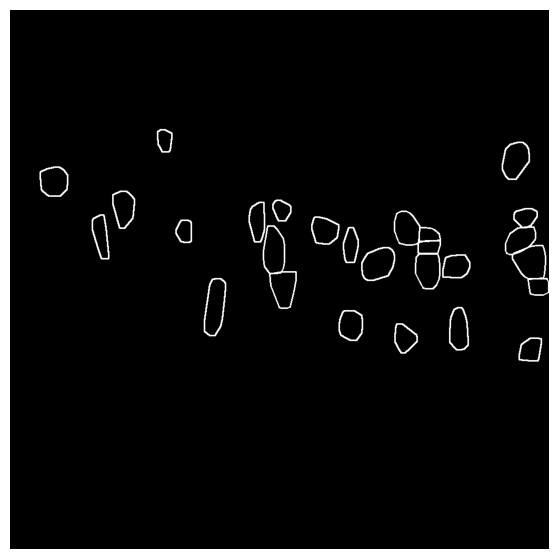

In [39]:
plot_image(initial_contours_of_cells, 7, 'gray')

After cells in initial frame are deteced we will track them using Multitracker + Boosting

In [144]:
# creating a video 'tracing_cells', in which we add every frame with bboxes of traced cells
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter('tracing_cells.avi', fourcc, 5, (1024, 1024))


# 'cells.avi' - created video from the obtained frames
cap = cv2.VideoCapture('cells.avi')
success, initial_frame = cap.read()

multiTracker = cv2.legacy.MultiTracker_create()

for bbox in initial_bboxes_of_cells:
    multiTracker.add(cv2.legacy.TrackerBoosting_create(), initial_frame, bbox)

In [145]:
all_bboxes = [initial_bboxes_of_cells]

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break


    # get updated location of objects in subsequent frames
    success, boxes = multiTracker.update(frame)
    all_bboxes.append(boxes)
    
    # draw bboxes of tracked cells
    for i, newbox in enumerate(boxes):
        p1 = (int(newbox[0]), int(newbox[1]))
        p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
        cv2.rectangle(frame, p1, p2, (255,255,255), 2)

    video.write(frame)
    cv2.imshow('MultiTracker', frame)

    if cv2.waitKey(1000) == 27:  # Esc pressed
        break

video.release()

In [169]:
def get_intensity_channel(frames, channel):
    """ return list of mean values of pixels in bboxes for each frame for a given channel index (0,1,2). """
    
    intensity_channel = []
    for i, frame in enumerate(frames[:,channel,:,:]):
        cell_intens_in_frame = []
        for bbox in all_bboxes[i]:
            p1 = (int(newbox[0]), int(newbox[1]))
            p2 = (int(newbox[0] + newbox[2]), int(newbox[1] + newbox[3]))
            cell_intensity = np.mean(frame[p1[1]:p2[1],p1[0]:p2[0]])
            cell_intens_in_frame.append(cell_intensity)
        intensity_per_frame = np.mean(cell_intens_in_frame)
        intensity_channel.append(intensity_per_frame)
    return intensity_channel

Hydrogen peroxide sensor HyPer has two maxima of fluorescence  at 420 and 500 nm, the channels data were recorded exactly at this wavelength.

In [170]:
hyper400 = get_intensity_channel(confocal_img_zones[0],1)
hyper500 = get_intensity_channel(confocal_img_zones[0],2)

In [171]:
hype_table = pd.DataFrame(list(zip(hyper400, hyper500)), columns=['hyper400','hyper500'])

In [172]:
hype_table['sec'] = hype_table.index * 20
hype_table['hyper_r'] = hype_table['hyper500'] / hype_table['hyper400']
hype_table['hyper_rn'] = hype_table['hyper_r'] / hype_table['hyper_r'][0:30].mean()

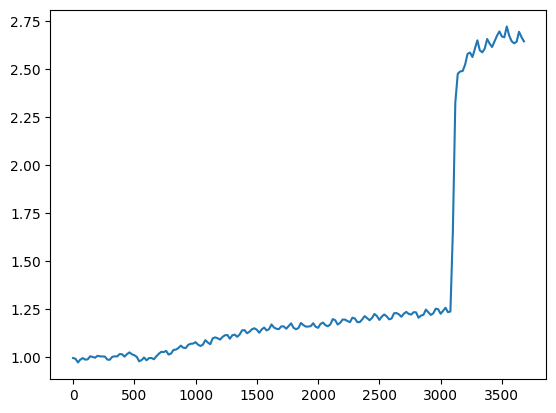

In [173]:
plt.plot(hype_table['sec'], hype_table['hyper_rn'])